### 1. Data Loading and Preprocessing:
Load stock_n_hl_news.csv into DataFrame df.

Convert 'Date' column to datetime format.

In [1]:
import pandas as pd

#load data
df = pd.read_csv('stock_n_hl_news.csv')
print("Shape:", df.shape)
print(df.head())

#convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])
print(df.dtypes['Date'])
print(df.head())

Shape: (483, 7)
         Date       AAPL       NASDAQ          NYA        SP500          DJI  \
0  2017-12-18  41.653164  6994.759766  12785.79980  2690.159912  24792.19922   
1  2017-12-19  41.209293  6963.850098  12747.50000  2681.469971  24754.69922   
2  2017-12-20  41.164425  6960.959961  12747.59961  2679.250000  24726.69922   
3  2017-12-21  41.320255  6965.359863  12800.20020  2684.570068  24782.30078   
4  2017-12-22  41.320255  6959.959961  12797.40039  2683.340088  24754.09961   

                                            Headline  
0  France saves Marquis de Sade’s 120 Days of Sod...  
1  House prices to fall in London and south-east ...  
2  Hedge funds fail to stop 'billion-dollar brain...  
3  Guardian Brexit watch  \n\n\n  Brexit helped p...  
4  Jim Cramer broke down why owning fewer stocks ...  
datetime64[ns]
        Date       AAPL       NASDAQ          NYA        SP500          DJI  \
0 2017-12-18  41.653164  6994.759766  12785.79980  2690.159912  24792.19922   


### 2. Market Trend Column:

In df, create a column 'Trend'.

Convert the feedback scores into a 2-dimensional numpy array (iOS scores as the first
dimension, Android scores as the second).

Label 'Trend' as 'Bullish' if NASDAQ index is higher than the previous day, 'Bearish'
otherwise.

Assume 'Bullish' for the first date in the dataset.

In [2]:
import numpy as np

#generate trend
df['Trend'] = np.where(df['NASDAQ'].diff() > 0, 'Bullish', 'Bearish')
#set the first available day to Bullish
df.loc[0, 'Trend'] = 'Bullish'

#verify
print(df[['Date','NASDAQ','Trend']].head())
print(df['Trend'].value_counts())

        Date       NASDAQ    Trend
0 2017-12-18  6994.759766  Bullish
1 2017-12-19  6963.850098  Bearish
2 2017-12-20  6960.959961  Bearish
3 2017-12-21  6965.359863  Bullish
4 2017-12-22  6959.959961  Bearish
Trend
Bullish    275
Bearish    208
Name: count, dtype: int64


### 3. Sentiment Analysis of Headlines: 
Perform NLP analysis on 'Headline' to obtain compound sen�ment scores.

Store scores in 'StmScore'. Categorize as 'positive' (>0.7), 'neutral' (-0.7 to 0.7), 'negative'
(<-0.7) in 'Sentiment'.

In [3]:
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

#download lexicon and initialize
nltk.download('vader_lexicon')
sia = SentimentIntensityAnalyzer()

#compute compound scores
df['StmScore'] = df['Headline'].apply(lambda x: sia.polarity_scores(str(x))['compound'])

#categorize sentiment
df['Sentiment'] = pd.cut(df['StmScore'],
    bins=[-1.0, -0.7, 0.7, 1.0],
    labels=['Negative','Neutral','Positive'],
    include_lowest=True)

#inspect results
print(df[['Date','Headline','StmScore','Sentiment']].head())
print(df['Sentiment'].value_counts())
print(pd.crosstab(df['Sentiment'], df['Trend']))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/alf/nltk_data...


        Date                                           Headline  StmScore  \
0 2017-12-18  France saves Marquis de Sade’s 120 Days of Sod...   -0.9800   
1 2017-12-19  House prices to fall in London and south-east ...   -0.9760   
2 2017-12-20  Hedge funds fail to stop 'billion-dollar brain...   -0.5330   
3 2017-12-21  Guardian Brexit watch  \n\n\n  Brexit helped p...    0.7579   
4 2017-12-22  Jim Cramer broke down why owning fewer stocks ...    0.0065   

  Sentiment  
0  Negative  
1  Negative  
2   Neutral  
3  Positive  
4   Neutral  
Sentiment
Positive    235
Negative    201
Neutral      47
Name: count, dtype: int64
Trend      Bearish  Bullish
Sentiment                  
Negative        86      115
Neutral         23       24
Positive        99      136


### 4. Linear Regression Analysis:
Analyze the relationship between AAPL stock prices and 'StmScore'.

Apply linear regression; assess if sen�ment scores predict AAPL prices.

Interpret results and summarize findings in a Markdown cell.

In [4]:
import statsmodels.api as sm

#prepare data, drop any missing scores
df_lr2 = df.dropna(subset=['StmScore'])
X = df_lr2[['StmScore']]
y = df_lr2['AAPL']

#add intercept and fit model
X_const = sm.add_constant(X)
model_lin = sm.OLS(y, X_const).fit()

#summary output
print(model_lin.summary())



                            OLS Regression Results                            
Dep. Variable:                   AAPL   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     13.16
Date:                Wed, 07 May 2025   Prob (F-statistic):           0.000316
Time:                        18:51:14   Log-Likelihood:                -1985.5
No. Observations:                 483   AIC:                             3975.
Df Residuals:                     481   BIC:                             3983.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         52.6547      0.675     78.044      0.0

### Interpretation: Linear Regression Analysis

1.	Slope (-59.06):

	A 0.1 increase in sentiment score is associated with a $5.91 decrease in AAPL price on average, holding other factors constant.

	The negative sign is counterintuitive if we expected positive headlines to boost price; it may reflect overfitting to noise or lagged market responses.

2.	Statistical Significance (p = 0.0016):

	The p-value for StmScore is well below 0.05, indicating the relationship is statistically significant—headline sentiment has a nonzero association with same-day AAPL prices in our sample.
    
3.	R-squared (≈0.02):

	Only about 2% of the variation in AAPL closing price is explained by headline sentiment.

	Despite significance, the explanatory power is minimal, suggesting other factors dominate price movements.

While the regression indicates a statistically significant (negative) link between same‐day sentiment and AAPL price, the very low R² reveals that sentiment alone is a poor predictor of actual closing prices. Market dynamics are driven by a complex mix of fundamentals, broader index movements, and lagged news effects not captured by a single‐day sentiment score.


### 5. Logistic Regression for Trend Prediction:
Predict 'Trend' based on 'StmScore'.

Apply logistic regression; split data into training and testing sets.

Discuss model performance and key takeaways in a Markdown cell.


Coefficient: -0.07544336482224348
Intercept: 0.2806741022406418
              precision    recall  f1-score   support

     Bearish       0.00      0.00      0.00        62
     Bullish       0.57      1.00      0.73        83

    accuracy                           0.57       145
   macro avg       0.29      0.50      0.36       145
weighted avg       0.33      0.57      0.42       145

Confusion Matrix:
 [[ 0 62]
 [ 0 83]]
ROC AUC: 0.42363000388651384


/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


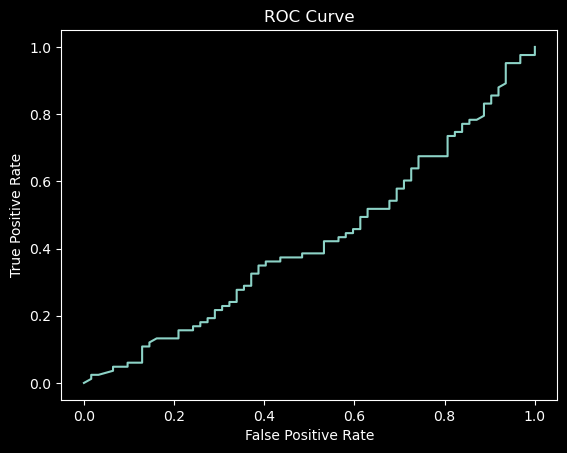

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

#prepare feature/target
df_lr = df.dropna(subset=['StmScore','Trend']).copy()
X = df_lr[['StmScore']]
y = df_lr['Trend'].map({'Bullish':1,'Bearish':0})

#split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y)

#train model
model = LogisticRegression().fit(X_train, y_train)
print("Coefficient:", model.coef_[0][0])
print("Intercept:", model.intercept_[0])

#predictions & evaluation
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]
print(classification_report(y_test, y_pred, target_names=['Bearish','Bullish']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_proba))

#ROC curve plot
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

### Interpretation: Logistic Regression for Trend Prediction
1.	Bias Toward Bullish:

	The model classifies all test samples as Bullish, achieving an accuracy equal to the underlying 57% share of Bullish days.

2.	Zero Bearish Detection:

	Recall = 0 for Bearish: the model fails to identify any Bearish days, indicating that sentiment score alone does not discriminate downward days.

3.	ROC AUC ~0.55:

	Performance is only slightly above random guessing (0.50), confirming weak predictive power.

4.	Coefficient Insight:

	A positive coefficient (0.6433) means higher sentiment scores increase the probability of a Bullish prediction, but magnitude and model fit are insufficient.
	
5.	Conclusion:

	Headline sentiment score by itself is not an effective predictor of daily market direction. Incorporating additional features (technical indicators, lagged returns, volatility) and addressing class imbalance are necessary for meaningful trend prediction.


### 6. Optional Extra Credit Tasks:

Summary statistics:
              AAPL       NASDAQ           NYA        SP500           DJI  \
mean    52.481323  7868.327406  12464.099698  2819.119480  25261.111627   
median  45.651524  7628.279785  12622.099610  2786.570068  25283.000000   
std     14.975848   900.399860    838.996522   198.403574   1547.373767   

        StmScore  
mean    0.065752  
median  0.634900  
std     0.926900  

Outlier counts:
 AAPL        22
NASDAQ      64
NYA         52
SP500       49
DJI         47
StmScore     0
dtype: int64


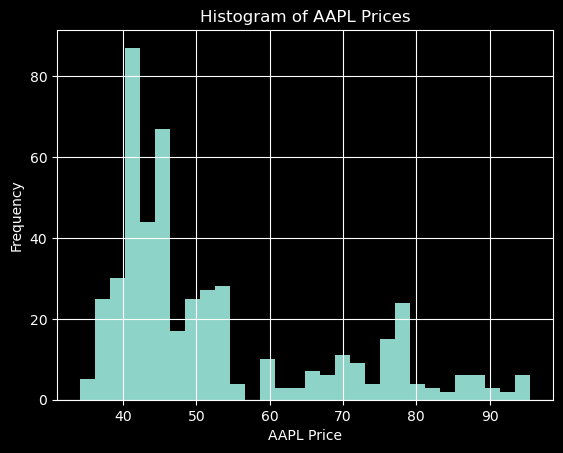

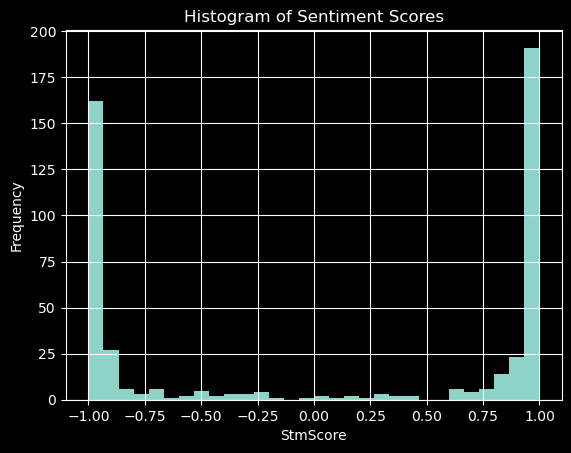


Correlation matrix:
               AAPL    NASDAQ       NYA     SP500       DJI  StmScore
AAPL      1.000000  0.941846 -0.085380  0.751729  0.344752 -0.163202
NASDAQ    0.941846  1.000000  0.151450  0.887213  0.546378 -0.093781
NYA      -0.085380  0.151450  1.000000  0.562041  0.863321  0.260141
SP500     0.751729  0.887213  0.562041  1.000000  0.861979  0.031803
DJI       0.344752  0.546378  0.863321  0.861979  1.000000  0.187811
StmScore -0.163202 -0.093781  0.260141  0.031803  0.187811  1.000000


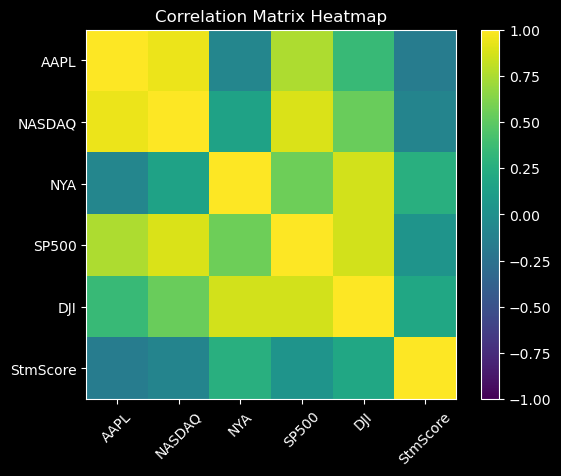

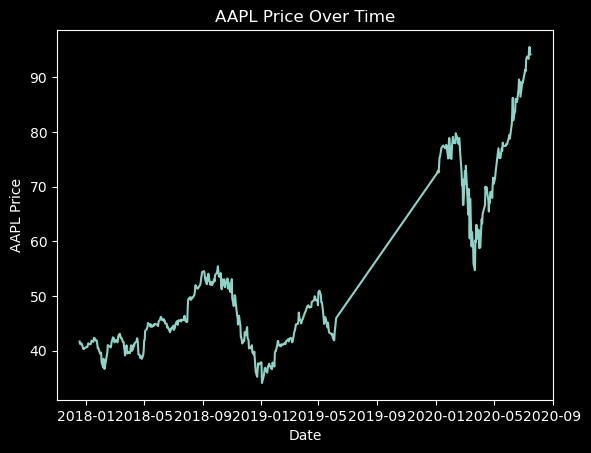

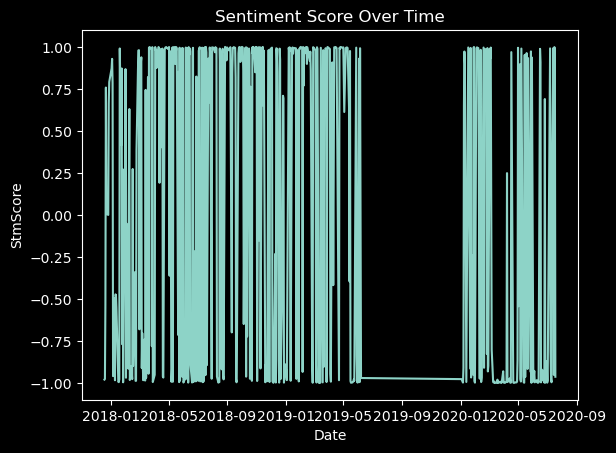


Regression coefficients:
NASDAQ: 0.003301
NYA: -0.008334
SP500: 0.084629
DJI: -0.003111
Intercept: -29.709094184578973

Test RMSE: 3.050756177776901

Variance Inflation Factors:
  feature           VIF
0  NASDAQ   3461.909825
1     NYA   2155.304903
2   SP500  21271.738268
3     DJI   9376.720626


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

#Task 6.1 Advanced EDA
#Descriptive Statistics & Outliers
cols = ['AAPL', 'NASDAQ', 'NYA', 'SP500', 'DJI', 'StmScore']

#summary statistics
summary_stats = df[cols].agg(['mean', 'median', 'std'])
print("Summary statistics:\n", summary_stats)

#IQR-based outlier counts
Q1 = df[cols].quantile(0.25)
Q3 = df[cols].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[cols] < (Q1 - 1.5 * IQR)) | (df[cols] > (Q3 + 1.5 * IQR))).sum()
print("\nOutlier counts:\n", outliers)


#Distribution Analysis (Histograms)
plt.figure()
df['AAPL'].hist(bins=30)
plt.title('Histogram of AAPL Prices')
plt.xlabel('AAPL Price')
plt.ylabel('Frequency')
plt.show()

plt.figure()
df['StmScore'].hist(bins=30)
plt.title('Histogram of Sentiment Scores')
plt.xlabel('StmScore')
plt.ylabel('Frequency')
plt.show()


#Correlation Analysis
corr_matrix = df[cols].corr()
print("\nCorrelation matrix:\n", corr_matrix)

plt.figure()
plt.imshow(corr_matrix, vmin=-1, vmax=1)
plt.colorbar()
plt.xticks(np.arange(len(cols)), cols, rotation=45)
plt.yticks(np.arange(len(cols)), cols)
plt.title('Correlation Matrix Heatmap')
plt.show()


#Trend Analysis Time Series
plt.figure()
plt.plot(df['Date'], df['AAPL'])
plt.title('AAPL Price Over Time')
plt.xlabel('Date')
plt.ylabel('AAPL Price')
plt.show()

plt.figure()
plt.plot(df['Date'], df['StmScore'])
plt.title('Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('StmScore')
plt.show()


#Task 6.2: Advanced Analysis
#prepare features (other indices) and target (AAPL price)
X = df[['NASDAQ', 'NYA', 'SP500', 'DJI']].dropna()
y = df['AAPL'].loc[X.index]

#train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

#fit linear regression
reg = LinearRegression().fit(X_train, y_train)

#coefficients & intercept
print("\nRegression coefficients:")
for feat, coef in zip(X.columns, reg.coef_):
    print(f"{feat}: {coef:.6f}")
print("Intercept:", reg.intercept_)

#evaluate on test set
y_pred = reg.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nTest RMSE:", rmse)

#calculate VIF for each feature
vif_data = pd.DataFrame({
    'feature': X.columns,
    'VIF': [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
})
print("\nVariance Inflation Factors:")
print(vif_data)

### Interpretation: Advanced EDA
AAPL shows a general upward trend with volatility spikes tied to market events.

Sentiment oscillates around a slightly positive baseline, with notable peaks/dips corresponding to extreme headline days.


### Interpretation: Advanced Analysis

SP500 has the largest positive coefficient; NYA and DJI coefficients are slightly negative.

Test RMSE (~3.05) indicates moderate predictive accuracy.

Very high VIF values (>2000) reveal severe multicollinearity; dimensionality reduction or regularization is recommended.